# A gentle introduction to Machine Learning

If you ask ChatGPT to describe ML you get something like this:

*Machine learning is a subset of artificial intelligence (AI) that focuses on developing algorithms and models that enable computers to learn and make predictions or decisions without being explicitly programmed for a particular task.*

Generally, ML contains two parts:
 - Selection of the model.
 - Tuning of the model's parameters.

If you know something about Bayesian statistic, this should sound familiar.

## Bayesian representation of Machine Learning

Bayesian probability is a framework in which the uncertainty is interpreted as a the degree of knowledge on a subject (prior), and the data is used to update this knowledge (posterior).

Let's take for example a simple regression problem:

\begin{equation}
    y = f(\mathbf{x}) + \epsilon.
\end{equation}

we want to find the function $f$ that relates our input $\mathbf{x}$ to the measured output $y$. But we also know that there are some uncertainties in our observation, that we indicate with $\epsilon$.

If we assume that the function $f$ is a linear function, and there is no noise, we can represent the problem as:

\begin{equation}
    y = \mathbf{x} \mathbf{w} + w_0
\end{equation}

The prior is the choice of the linear model, and the data is used to select the weights $\mathbf{w}$ of the model.

The weights are chosen by minimising some error metric, like the $l_2$ norm:

\begin{equation}
    \mathrm{arg min} || y - (\mathbf{x}\mathbf{w} + w_0)||^2_2
\end{equation}

## Example
Let's make a simple example, in which we try to predict the NO emissions given the equivalence ratio.


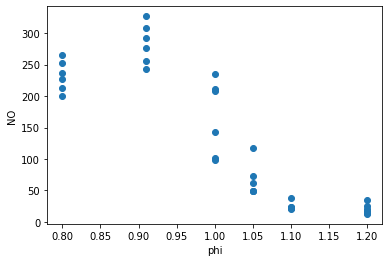

In [2]:
# A quick example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('emissions_furnace.csv')
x = data[['phi']]
y = data[['NO']]

plt.scatter(x['phi'], y)
plt.xlabel('phi')
plt.ylabel('NO')
plt.show()

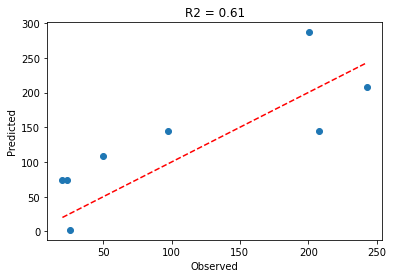

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12345)

x0_train = (x_train - np.mean(x_train))/np.std(x_train)
x0_test = (x_test - np.mean(x_train))/np.std(x_train)

lr = LinearRegression().fit(x0_train, y_train)
y_pred = lr.predict(x0_test)
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', c='r')
plt.title(f'R2 = {r2:.2f}')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()


## What methods do we use to find the optimal models parameters?

Depending on the type of the problem, the optimisation of the parameter can be done in different ways.
If the problem is convex, the optimisation can be done using convex optimisation methods (CVXPY).

This choice has some important benefits:
- The solution is global
- We can put (linear) constraints on the parameters

### Example using CVXPY

We solve the same linear regression problem using convex optimisation.

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 12 02:28:07 PM: Your problem has 2 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 12 02:28:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 12 02:28:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 12 02:28:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 12 02:28:07 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 12 02:28:07 PM: Compiling problem (target solver=OSQP).
(CVXP

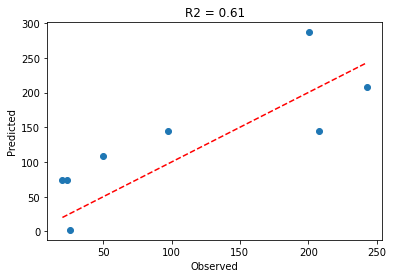

In [4]:
import cvxpy as cp

w = cp.Variable()
w0 = cp.Variable()
objective = cp.Minimize(cp.sum_squares(y_train - (x0_train * w + w0)))
prob = cp.Problem(objective)

result = prob.solve(verbose=True)

y_pred = x0_test * w.value + w0.value
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', c='r')
plt.title(f'R2 = {r2:.2f}')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()


The cool thing about CVXPY is that we can easily modify the objective function, or we can introduce some constraints in the solution. For example, let's say that we know that the NO concentration cannot be greater than 250 ppm:

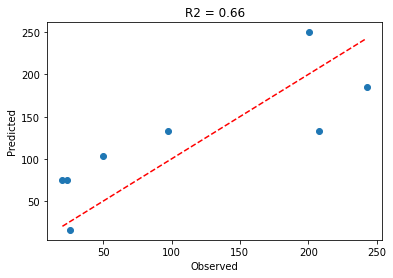

In [5]:
w = cp.Variable()
w0 = cp.Variable()
objective = cp.Minimize(cp.sum_squares(y_train - (x0_train * w + w0)))
constraints = [x0_train * w + w0 <= 250]
prob = cp.Problem(objective, constraints)

result = prob.solve(verbose=False)

y_pred = x0_test * w.value + w0.value
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', c='r')
plt.title(f'R2 = {r2:.2f}')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

We can also modify the objective functions to include a penalty for the model's complexity (regularisation). For example, we can put a penalty on the $l_2$ norm of the weights. This is called Ridge regularisation, and it is helpful when the input features are correlated (co-linearity):

\begin{equation}
    \mathrm{arg min} || y - (\mathbf{x}\mathbf{w} + w_0)||^2_2 + \alpha||\mathbf{w}||^2_2
\end{equation}


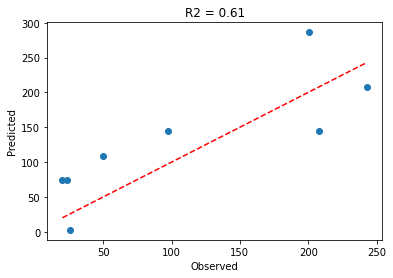

In [11]:
w = cp.Variable()
w0 = cp.Variable()

alpha = 0.1
objective = cp.Minimize(cp.sum_squares(y_train - (x0_train * w + w0)) + alpha*cp.pnorm(w, p=2)**2)
prob = cp.Problem(objective)

result = prob.solve(verbose=False, solver='CLARABEL')

y_pred = x0_test * w.value + w0.value
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', c='r')
plt.title(f'R2 = {r2:.2f}')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

## And if the problem is not convex?

If your objective function is not convex, the other option is to use local methods such the gradient descent.Basically, to find the (local) minimum of the loss function, we follow the direction where the gradient is steepest.
This methodology is the most common when training neural networks.

## Example using Pytorch

In this example we show how we can use a neural network to solve a OLS, regression problem, and how we can modify it to introduce a non-linear behaviour.

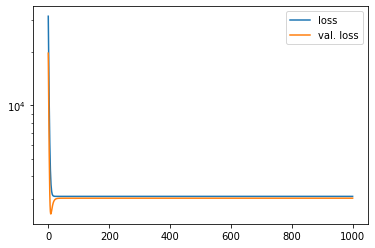

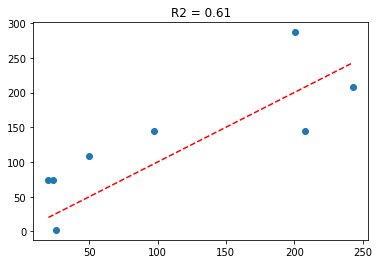

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple linear neural network
class LinearNN(nn.Module):
    def __init__(self):
        super(LinearNN, self).__init__()
        # Define the linear layer with two input nodes and one output node
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        # Apply the linear activation
        output = self.linear(x)
        return output

# Create an instance of the simple neural network
model_lin = LinearNN()

# Define a loss function (mean squared error)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model_lin.parameters(), lr=0.1)

x0_train_torch = torch.from_numpy(x0_train).float()
x0_test_torch = torch.from_numpy(x0_test).float()
y_train_torch = torch.from_numpy(y_train).float()
y_test_torch = torch.from_numpy(y_test).float()

n_iter = 1000
loss_array = np.zeros((n_iter,))
val_loss_array = np.zeros((n_iter,))

for i in range(n_iter):
    optimizer.zero_grad()  # Zero the gradients to avoid accumulation
    output = model_lin(x0_train_torch)
    loss = criterion(output, y_train_torch)
    loss_array[i] = loss.item()
    
    output_val = model_lin(x0_test_torch)
    val_loss = criterion(output_val, y_test_torch)
    val_loss_array[i] = val_loss.item()

    # Perform backpropagation and update the weights
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights

plt.plot(loss_array, label='loss')
plt.plot(val_loss_array, label='val. loss')
plt.yscale('log')
plt.legend()
plt.show()

# Check the updated output after training
y_pred = model_lin(x0_test_torch).detach().numpy()
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', c='r')
plt.title(f'R2 = {r2:.2f}')
plt.show()


To introduce the non-linearity, we create a hidden layer with two nodes inside the neural network, using the Sigmoid activation function.

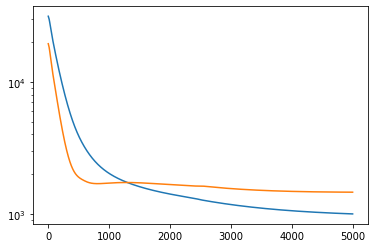

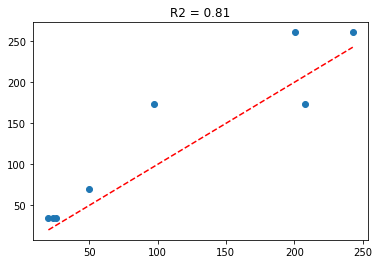

In [13]:
import torch.nn.functional as F

class NonLinearNN(nn.Module):
    def __init__(self):
        super(NonLinearNN, self).__init__()
        self.linear1 = nn.Linear(1, 2)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2,1)
        
    def forward(self, x):
        hidden = self.sigmoid(self.linear1(x))
        output = self.linear2(hidden)
        return output

model_nl = NonLinearNN()
criterion = nn.MSELoss()
optimizer = optim.SGD(model_nl.parameters(), lr=0.001)

n_iter = 5000
loss_array = np.zeros((n_iter,))
val_loss_array = np.zeros((n_iter,))

for i in range(n_iter):
    optimizer.zero_grad()  # Zero the gradients to avoid accumulation
    output = model_nl(x0_train_torch)
    loss = criterion(output, y_train_torch)
    loss_array[i] = loss.item()

    output_val = model_nl(x0_test_torch)
    val_loss = criterion(output_val, y_test_torch)
    val_loss_array[i] = val_loss.item()

    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights

plt.plot(loss_array)
plt.plot(val_loss_array)
plt.yscale('log')
plt.show()

y_pred = model_nl(x0_test_torch).detach().numpy()
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', c='r')
plt.title(f'R2 = {r2:.2f}')
plt.show()

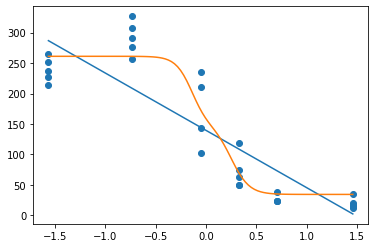

In [14]:
x_new = np.linspace(x_train.min(), x_train.max(), 100)
x0_new = (x_new - np.mean(x_train))/np.std(x_train)
x0_new_torch = torch.from_numpy(x0_new.reshape(-1, 1)).float()

y_new_ls = lr.predict(x0_new.reshape(-1, 1))
y_new_nn = model_nl(x0_new_torch).detach().numpy()

plt.plot(x0_new, y_new_ls)
plt.plot(x0_new, y_new_nn)
plt.scatter(x0_train, y_train)
plt.show()

## A more Bayesian framework

Gaussian Process Regression is a framework in which we assume that the function that we want to model is a sample from a multivariate Gaussian distribution.

So we assume that the prior is a multivariate Gaussian distribution with zero mean, and the covariance matrix is computed using a kernel function.


/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


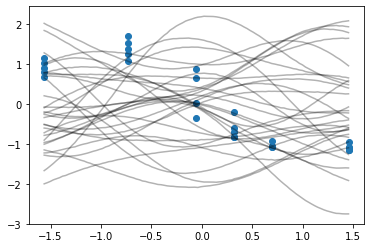

In [16]:
import gpytorch
from gpytorch.distributions import MultivariateNormal

y0_train = (y_train - np.mean(y_train))/np.std(y_train)
y0_train_torch = torch.from_numpy(y0_train).float()

# The output of model is a gaussian distribution that we can sample

mean = gpytorch.means.ConstantMean()
kernel = gpytorch.kernels.RBFKernel()
kernel.lengthscale = 1.
mvdist = MultivariateNormal(mean(x0_new_torch), 
                            kernel(x0_new_torch))

n_samples = 30
samples = mvdist.sample(torch.Size([n_samples]))

for i in range(n_samples):
    plt.plot(x0_new_torch, samples[i, :], c='k', alpha=0.3)
plt.scatter(x0_train, y0_train)
plt.show()

The training is done to select the optimal hyperparameters, by maximizing the marginal log likelihood.



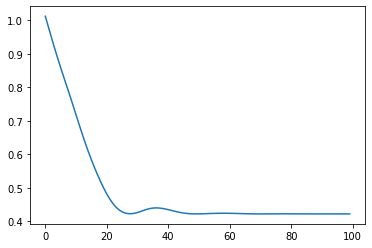

In [17]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model_gp = GPModel(x0_train_torch.flatten(), y0_train_torch.flatten(), likelihood)

# Find optimal model hyperparameters
model_gp.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_gp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gp)

n_iter = 100
loss_array = np.zeros((n_iter,))
for i in range(n_iter):
    optimizer.zero_grad()
    output = model_gp(x0_train_torch.flatten())
    loss = -mll(output, y0_train_torch.flatten())
    loss_array[i] = loss.item()
    loss.backward()

    optimizer.step()

plt.plot(loss_array)
plt.show()



Then, we compute the predictive posterior by conditioning the joint distribution between the training and new data on the observed data.

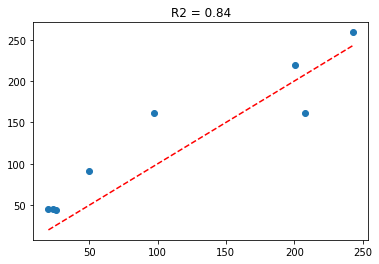

/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


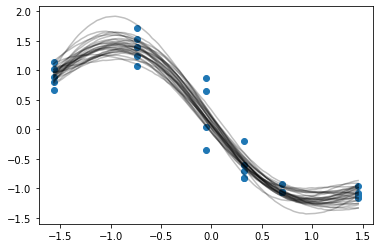

In [26]:
model_gp.eval()
likelihood.eval()

y_pred = np.std(y_test)*model_gp(x0_test_torch).mean.detach().numpy() + np.mean(y_train)
r2 = r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', c='r')
plt.title(f'R2 = {r2:.2f}')
plt.show()


n_samples = 30
samples = model_gp(x0_new_torch).sample(torch.Size([n_samples]))

for i in range(n_samples):
    plt.plot(x0_new_torch, samples[i, :], c='k', alpha=0.25)
plt.scatter(x0_train, y0_train)
plt.show()

## Latent space representation

When we deal with high dimensional data coming from a physical process, we can expect that there exist a low-dimensional manifold in which we can embed the original data.

We can have an intuition of the latent space (the space of the low-dimensional manifold) by considering some images of a flame.

### Example: latent-dimensional representation of a flame

Let's consider 1024 consecutive images of a flame, where each image has a 32x32 resolution.
Each image can be considered a point in a 32 * 32 = 1024 dimensional space. However, only an infinitesimally small part of this space represents flames. Statistically, the vast majority of the space is noise.

We can say that the space is sparse, and we can leverage this sparsity to compress the dimensionality while preserving the original information.

To do this we can use the POD to find a transforming basis that is trained to represent the flames. The new basis U is a proper basis, so it can represent all the 1024-dimensional points. However, it is optimised to represent the flames used to find the new basis.

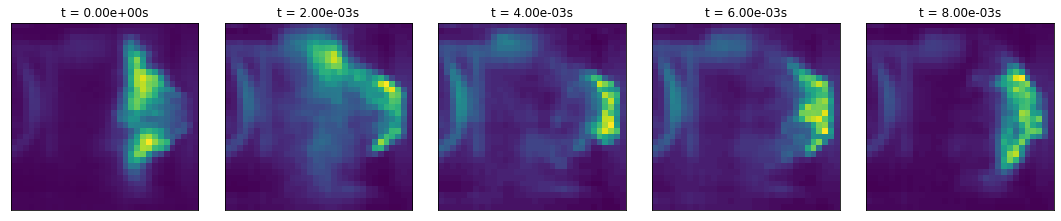

In [36]:

X = np.load('X_100_r32.npy')

resolution = (32,32)
dt = 1/2500

fig, axs = plt.subplots(ncols=5, figsize=(15,3))
for i in range(5):
    axs[i].imshow(X[:,5*i].reshape(resolution))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f't = {5*i*dt:.2e}s')

fig.tight_layout()

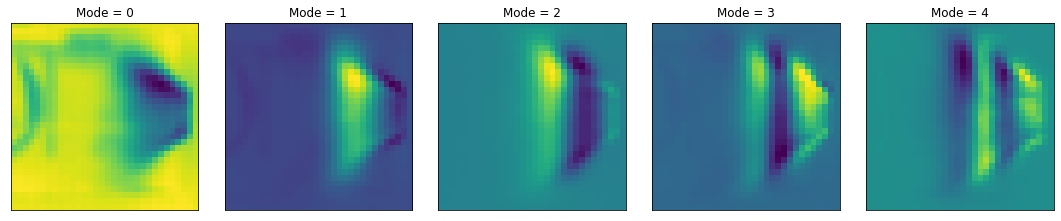

In [37]:
U, Sigma, Vt = np.linalg.svd(X)
A = np.transpose(np.diag(Sigma) @ Vt)

fig, axs = plt.subplots(ncols=5, figsize=(15,3))
for i in range(5):
    axs[i].imshow(U[:,i].reshape(resolution))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f'Mode = {i}')

fig.tight_layout()

By combining the POD modes we can efficiently reconstruct the flame using few scalars. However, the POD modes represent a basis for the 1024-dimensional space, so in theory we can use them to represent whatever we want.

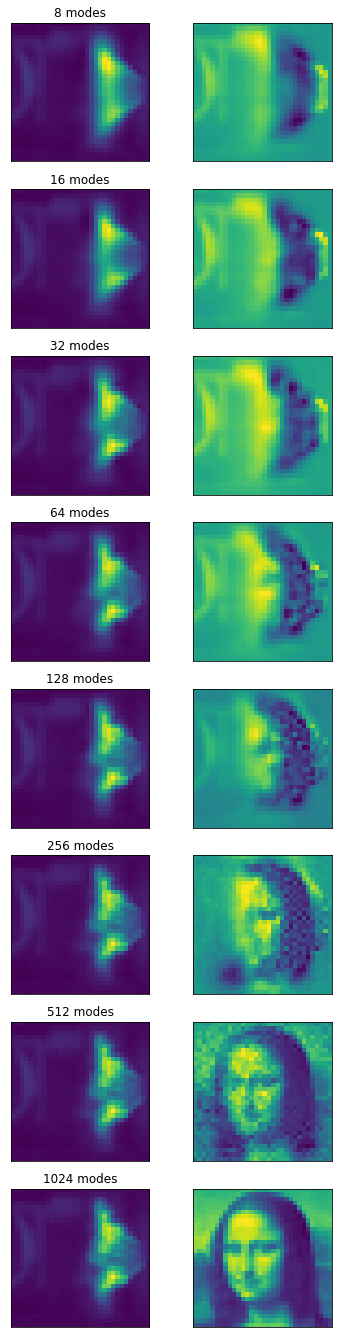

In [42]:
from PIL import Image

def plot_rec():
    fig, axs = plt.subplots(8, 2, figsize=(6, 24))
    n_modes = [2**i for i in range(3, 11)]
    for i, n in enumerate(n_modes):
        axs[i,0].imshow(np.matmul(U[:, :n],a_0[:n]).reshape(resolution))
        axs[i,1].imshow(np.matmul(U[:, :n],a_image[:n]).reshape(resolution))
        
        axs[i,0].set_title(f'{n} modes')
        
        for j in range(2):
            axs[i,j].axes.get_xaxis().set_visible(False)
            axs[i,j].axes.get_yaxis().set_visible(False)

image = Image.open(f'monalisa.png').convert('L')
image = np.array(image.resize((32, 32)))/255.

U, Sigma, Vt = np.linalg.svd(X)
A = np.transpose(np.diag(Sigma) @ Vt)

a_0 = A[0,:]
a_image = U.T @ image.flatten()

plot_rec()

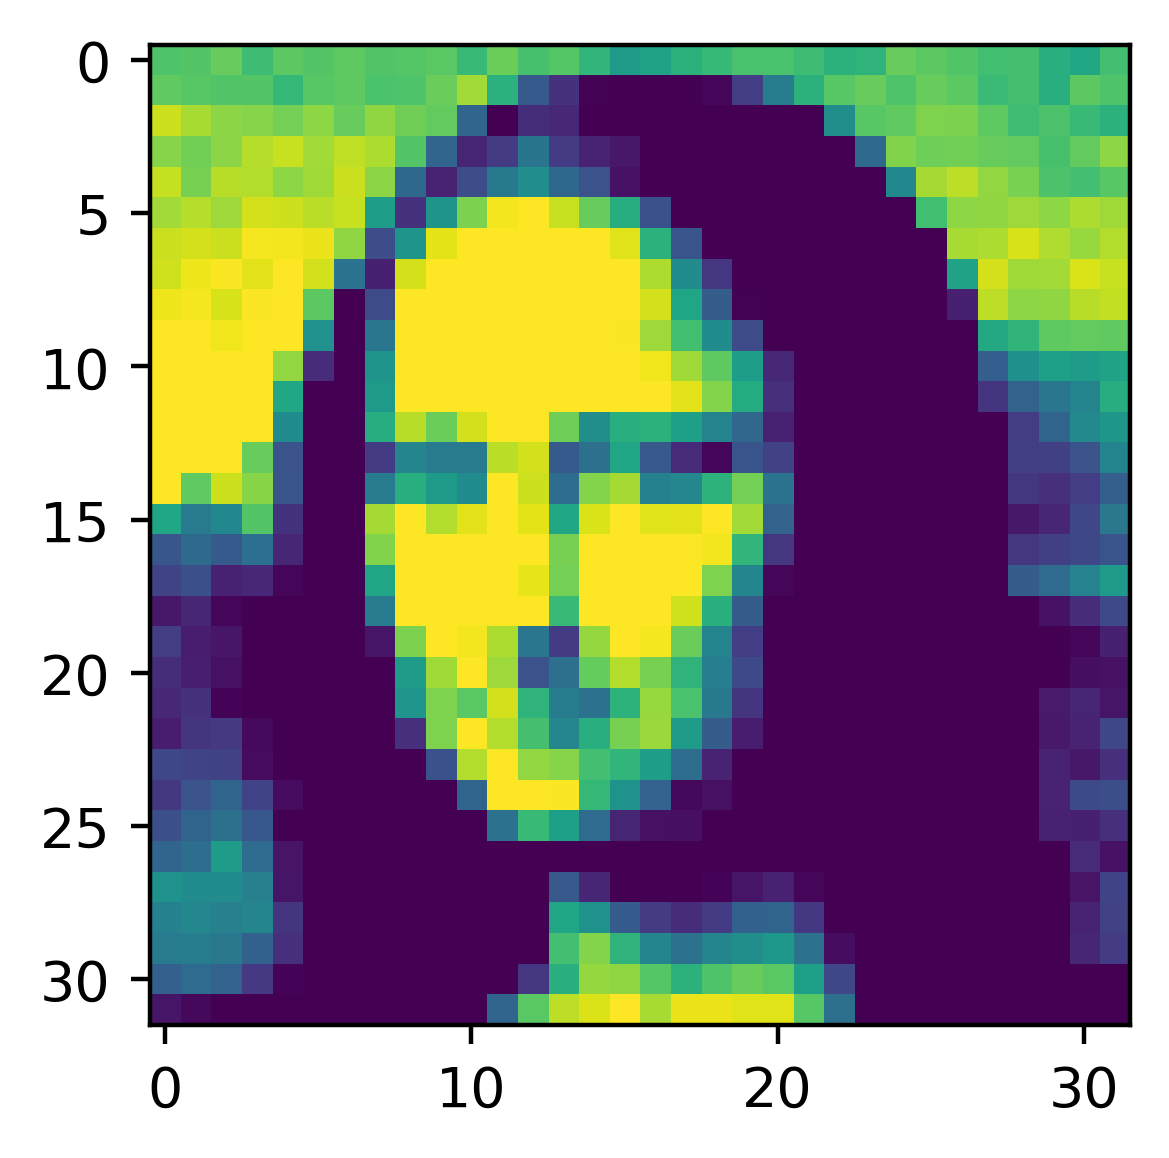

In [43]:
# Create the animation

from matplotlib.animation import FuncAnimation 
from IPython.display import HTML

def animate(i):
    im.set_array(np.matmul(U[:, :i*16],a_image[:i*16]).reshape(resolution))
    
    return im

fps = 25

fig = plt.figure(figsize=(6,3), dpi=400)
ax = fig.add_subplot(1,1,1)

im = ax.imshow(np.matmul(U[:, :1],a_image[:1]).reshape(resolution))

fig.tight_layout()

anim = FuncAnimation(fig, animate, frames=64)
HTML(anim.to_jshtml())